<a href="https://colab.research.google.com/github/FrancescoManca-FM/Project_MLDL/blob/main/incrementalLearningWithoutForgetting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia -smi

In [ ]:
import torch 
import torchvision
import torchvision.transforms as transforms 
import torch.nn.functional as F
import copy
from torch.nn.init import xavier_uniform_ 
from torch.nn.init import kaiming_uniform_

### DATA LOADER

In [ ]:
# we build a transform to normalize images: Data normalization is an important step which ensures 
# each input parameter (pixel, in this case) has a similar data distribution. This makes convergence 
# faster while training the network.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 128

trainset_raw = torchvision.datasets.CIFAR100(root='./data', train=True, 
                                         download=True, transform=transform)

for i in range(len(trainset_raw)):
  if(i==0):
    trainset = [[trainset_raw[i][0], trainset_raw[i][1]]]
  else:
    trainset.append([trainset_raw[i][0], trainset_raw[i][1]])


# DataLoader. Combines a dataset and a sampler, and provides an iterable over the given dataset.
# batch_size = how many samples per batch to load
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset_raw = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
for i in range(len(testset_raw)):
  if(i==0):
    testset = [[testset_raw[i][0], testset_raw[i][1]]]
  else:
    testset.append([testset_raw[i][0], testset_raw[i][1]])
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### NETWORK

In [ ]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10):
        self.inplanes = 16
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.avgpool = nn.AvgPool2d(8, stride=1)

        self.fc = nn.Linear(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

    # def addOutputNodes(self, num_new_outputs):
    #     in_features = self.fc.in_features
    #     out_features = self.fc.out_features
    #     weight = self.fc.weight.data

    #     self.fc = nn.Linear(in_features, out_features + num_new_outputs)

    #     #xavier initialization
    #     xavier_uniform_(self.fc.weight)
        
    #     self.fc.weight.data[:out_features] = weight
        
def resnet32(pretrained=False, **kwargs):
    n = 5
    model = ResNet(BasicBlock, [n, n, n], **kwargs)
    return model

In [ ]:
class LWF(nn.Module):
  def __init__(self, feature_size, n_classes):
    super(LWF,self).__init__()
    self.feature_extractor = resnet32()
    self.feature_extractor.fc = nn.Linear(self.feature_extractor.fc.in_features, feature_size)
    self.bn =  nn.BatchNorm1d(feature_size, momentum=0.9)
    self.ReLU = nn.ReLU()

    self.fc = nn.Linear(feature_size, n_classes, bias = False)

  def forward(self, x):
    x = self.feature_extractor(x)
    x = self.bn(x)
    x = self.ReLU(x)
    x = self.fc(x)

    return x

  def increment_classes(self, n):
    """Add n classes in the final fc layer"""
    in_features = self.fc.in_features
    out_features = self.fc.out_features
    weight = self.fc.weight.data

    #xavier initialization
    # xavier_uniform_(self.fc.weight)

    self.fc = nn.Linear(in_features, out_features + n, bias = False)
    self.fc.weight.data[:out_features] = weight

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
feature_size = 2048
n_classes = 10
net = LWF(feature_size, n_classes)
net.to(device)

LWF(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, 

### LOSS & PARAMETERS

In [ ]:
lr = 2
decay = 0.00001
epochs = 70
momentum = 0.9
factor = 5

In [ ]:
import torch.optim as optim
import torch.nn as nn

bceLoss = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr = lr, weight_decay=decay,momentum= momentum)

### TRAINING BCE LOSS

In [ ]:
# def training(trainloader, iteration, network, device, epochs, num_classes):

#   num_classes_till_previous_step = iteration * num_classes
#   num_current_classes = num_classes_till_previous_step + num_classes
#   total_classes = 100

#   distillation_loss = 0

#   old_net = copy.deepcopy(network)
#   old_net.eval()
  
#   if (iteration != 0):
#     # add 10 output nodes to the network
#     network.increment_classes(num_classes)
#     network.to(device)

#   optimizer = optim.SGD(network.parameters(), lr = lr, weight_decay=decay,momentum= momentum)
 
 
#   #train the network
#   for epoch in range(epochs):
#     if (epoch == 49 or epoch == 63):
#      optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] / factor

#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#       inputs = data[0].to(device)
#       labels = data[1].to(device)
#       optimizer.zero_grad()
#       logits = network.forward(inputs)
#       distilled_targets = get_one_hot(labels, num_current_classes, device)
      
#       if iteration > 0:
#         logits_old = old_net(inputs)
#         distilled_targets[:, 0:num_classes_till_previous_step] = torch.sigmoid(logits_old)

#       loss = bceLoss(logits, distilled_targets) #* (num_current_classes / total_classes)

#       # redesign the weights evaluating the performance of the network
#       loss.backward()
#       # update parameters
#       optimizer.step()

#       running_loss += loss.item()
#       if i % 20 == 19:    
#         print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 20))
#         running_loss = 0.0

#   return network

In [ ]:
# def get_one_hot(target,num_class, device):
#   one_hot=torch.zeros(target.shape[0],num_class).to(device)
#   one_hot=one_hot.scatter(dim=1,index=target.long().view(-1,1),value=1.)
#   return one_hot

### training (daniele)

In [ ]:
def training(trainloader, iteration, network, device, epochs, num_classes):
  
  num_classes_till_previous_step = iteration * num_classes
  num_current_classes = num_classes_till_previous_step + num_classes
  total_classes = 100

  distillation_loss = 0
  
  old_net = copy.deepcopy(network)
  old_net.eval()
  
  if (iteration != 0):
    # add 10 output nodes to the network
    network.increment_classes(num_classes)
    network.to(device)

  net = network.feature_extractor
  net = net.to(device)

  optimizer = optim.SGD(network.parameters(), lr = lr, weight_decay=decay,momentum= momentum)
 
  network.train()

  #train the network
  for epoch in range(epochs):
    if (epoch == 49 or epoch == 63):
     optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] / factor

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
      inputs = data[0].to(device)
      labels = data[1].to(device)

      optimizer.zero_grad()

      logits = network.forward(inputs)

      distilled_targets = get_one_hot(labels, num_current_classes, device)
      
      if iteration > 0:
        logits_old = old_net(inputs)
        distilled_targets[:, 0:num_classes_till_previous_step] = torch.sigmoid(logits_old)


      loss = bceLoss(logits, distilled_targets) * (num_current_classes / total_classes)

      # redesign the weights evaluating the performance of the network
      loss.backward()
      # update parameters
      optimizer.step()

      running_loss += loss.item()
      if i % 20 == 19:    
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 20))
        running_loss = 0.0
  del net

### TEST

In [ ]:
"""
def test(testloader, iteration, network, acc):

  correct = 0
  total = 0
  print("ITERATION: ", iteration)
  
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in testloader:
          images, labels = data[0].to(device), data[1].to(device)

          # calculate outputs by running images through the network
          outputs = network.forward(images)

          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
         
        
  acc.append(100*correct/total)
  print(f'Accuracy of the network on the {iteration} iteration: %d %%' % (100 * correct / total))
  """

'\ndef test(testloader, iteration, network, acc):\n\n  correct = 0\n  total = 0\n  print("ITERATION: ", iteration)\n  \n  # since we\'re not training, we don\'t need to calculate the gradients for our outputs\n  with torch.no_grad():\n      for data in testloader:\n          images, labels = data[0].to(device), data[1].to(device)\n\n          # calculate outputs by running images through the network\n          outputs = network.forward(images)\n\n          # the class with the highest energy is what we choose as prediction\n          _, predicted = torch.max(outputs.data, 1)\n          total += labels.size(0)\n          correct += (predicted == labels).sum().item()\n         \n        \n  acc.append(100*correct/total)\n  print(f\'Accuracy of the network on the {iteration} iteration: %d %%\' % (100 * correct / total))\n  '

### EXECUTION 

In [ ]:
"""
# divided our dataset into sample of 10 classes each
# train the network on the first 10 classes
# evaluate the network on the first 10 classes
# train the network on the second 10 classes (adding 10 output layers)
# evaluate the network on the first 20 classes
iterations= 10 
num_classes = 10
test_set = [] #initialized here because we test over all the classes not only those one in which I train
acc = []
import random
#indices = list(range(0,100))
#random.shuffle(indices)
for i in range(iterations):
  classes_current_iter = range(i*num_classes, i*num_classes+num_classes)
  train_iter = [] 
  for j in range(len(trainset)):
    if(trainset[j][-1] in classes_current_iter):
      test_set.append(trainset[j]) 
      train_iter.append(trainset[j])


  train_loader = torch.utils.data.DataLoader(train_iter, shuffle = True, batch_size=batch_size, num_workers=2)
  valid_loader = torch.utils.data.DataLoader(test_set, shuffle = True, batch_size = batch_size, num_workers=2) 
  training(train_loader, i, net, device, epochs, num_classes) # Train the network with 10 classes at a time

  test(valid_loader, i, net, acc) # Test the network with all classes seen until this iteration
  """

'\n# divided our dataset into sample of 10 classes each\n# train the network on the first 10 classes\n# evaluate the network on the first 10 classes\n# train the network on the second 10 classes (adding 10 output layers)\n# evaluate the network on the first 20 classes\niterations= 10 \nnum_classes = 10\ntest_set = [] #initialized here because we test over all the classes not only those one in which I train\nacc = []\nimport random\n#indices = list(range(0,100))\n#random.shuffle(indices)\nfor i in range(iterations):\n  classes_current_iter = range(i*num_classes, i*num_classes+num_classes)\n  train_iter = [] \n  for j in range(len(trainset)):\n    if(trainset[j][-1] in classes_current_iter):\n      test_set.append(trainset[j]) \n      train_iter.append(trainset[j])\n\n\n  train_loader = torch.utils.data.DataLoader(train_iter, shuffle = True, batch_size=batch_size, num_workers=2)\n  valid_loader = torch.utils.data.DataLoader(test_set, shuffle = True, batch_size = batch_size, num_workers=2

### CONFUSION MATRIX

In [ ]:
"""
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

confusion_matrix = torch.zeros(100,100)

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in valid_loader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net.forward(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for t, p in zip(labels.view(-1), predicted.view(-1)):
          confusion_matrix[t.long(),p.long()] += 1

plt.figure()
plt.imshow(confusion_matrix, interpolation="nearest", cmap=plt.cm.Blues)
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
"""

'\nfrom sklearn.metrics import plot_confusion_matrix\nimport matplotlib.pyplot as plt\n\nconfusion_matrix = torch.zeros(100,100)\n\ncorrect = 0\ntotal = 0\n# since we\'re not training, we don\'t need to calculate the gradients for our outputs\nwith torch.no_grad():\n    for data in valid_loader:\n        images, labels = data[0].to(device), data[1].to(device)\n        # calculate outputs by running images through the network\n        outputs = net.forward(images)\n        # the class with the highest energy is what we choose as prediction\n        _, predicted = torch.max(outputs.data, 1)\n        total += labels.size(0)\n        correct += (predicted == labels).sum().item()\n\n        for t, p in zip(labels.view(-1), predicted.view(-1)):\n          confusion_matrix[t.long(),p.long()] += 1\n\nplt.figure()\nplt.imshow(confusion_matrix, interpolation="nearest", cmap=plt.cm.Blues)\nprint(\'Accuracy of the network on the 10000 test images: %d %%\' % (100 * correct / total))\n'

### TEST (CONFUSION EACH STEP)



In [ ]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

def test(testloader, iteration, network, acc):
  confusion_matrix = torch.zeros(iteration*10+10,iteration*10+10)
  print("confusion matrix shape: ", confusion_matrix.shape)
  correct = 0
  total = 0
  print("ITERATION: ", iteration)
  network.eval()
  
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in testloader:
          images, labels = data[0].to(device), data[1].to(device)

          # calculate outputs by running images through the network
          outputs = network.forward(images)

          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(torch.softmax(network.forward(images), dim=1), dim=1, keepdim=False)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
         
          for t, p in zip(labels.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(),p.long()] += 1

  plt.figure()
  plt.imshow(confusion_matrix, interpolation="nearest", cmap=plt.cm.jet)
  plt.show()
  acc.append(100*correct/total)
  print(f'Accuracy of the network on the {iteration} iteration: %d %%' % (100 * correct / total))

### RANDOM CLASSES


EXECUTION

In [ ]:
import random
indices = list(range(0,100))
random.shuffle(indices)
dict_classes = dict(zip(indices,range(100)))
for i in range(len(trainset)):
  trainset[i][1] = dict_classes[trainset[i][1]]

Train the network, iteration:  0  on classes:  range(0, 10)
[1,    20] loss: 0.039
[1,    40] loss: 0.031
[2,    20] loss: 0.030
[2,    40] loss: 0.031
[3,    20] loss: 0.029
[3,    40] loss: 0.030
[4,    20] loss: 0.030
[4,    40] loss: 0.027
[5,    20] loss: 0.027
[5,    40] loss: 0.025
[6,    20] loss: 0.025
[6,    40] loss: 0.024
[7,    20] loss: 0.025
[7,    40] loss: 0.027
[8,    20] loss: 0.026
[8,    40] loss: 0.022
[9,    20] loss: 0.022
[9,    40] loss: 0.023
[10,    20] loss: 0.024
[10,    40] loss: 0.023
[11,    20] loss: 0.024
[11,    40] loss: 0.022
[12,    20] loss: 0.020
[12,    40] loss: 0.021
[13,    20] loss: 0.023
[13,    40] loss: 0.025
[14,    20] loss: 0.021
[14,    40] loss: 0.019
[15,    20] loss: 0.022
[15,    40] loss: 0.020
[16,    20] loss: 0.022
[16,    40] loss: 0.024
[17,    20] loss: 0.022
[17,    40] loss: 0.029
[18,    20] loss: 0.024
[18,    40] loss: 0.021
[19,    20] loss: 0.018
[19,    40] loss: 0.022
[20,    20] loss: 0.020
[20,    40] loss: 0.01

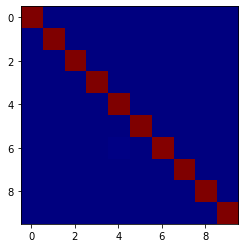

Accuracy of the network on the 0 iteration: 99 %
Train the network, iteration:  1  on classes:  range(10, 20)
[1,    20] loss: 0.055
[1,    40] loss: 0.045
[2,    20] loss: 0.041
[2,    40] loss: 0.036
[3,    20] loss: 0.034
[3,    40] loss: 0.033
[4,    20] loss: 0.031
[4,    40] loss: 0.029
[5,    20] loss: 0.027
[5,    40] loss: 0.026
[6,    20] loss: 0.024
[6,    40] loss: 0.023
[7,    20] loss: 0.021
[7,    40] loss: 0.021
[8,    20] loss: 0.021
[8,    40] loss: 0.020
[9,    20] loss: 0.018
[9,    40] loss: 0.018
[10,    20] loss: 0.018
[10,    40] loss: 0.018
[11,    20] loss: 0.023
[11,    40] loss: 0.021
[12,    20] loss: 0.021
[12,    40] loss: 0.018
[13,    20] loss: 0.015
[13,    40] loss: 0.014
[14,    20] loss: 0.014
[14,    40] loss: 0.014
[15,    20] loss: 0.018
[15,    40] loss: 0.016
[16,    20] loss: 0.014
[16,    40] loss: 0.014
[17,    20] loss: 0.018
[17,    40] loss: 0.015
[18,    20] loss: 0.015
[18,    40] loss: 0.013
[19,    20] loss: 0.014
[19,    40] loss: 0.

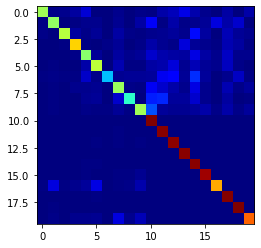

Accuracy of the network on the 1 iteration: 73 %
Train the network, iteration:  2  on classes:  range(20, 30)
[1,    20] loss: 0.058
[1,    40] loss: 0.048
[2,    20] loss: 0.050
[2,    40] loss: 0.045
[3,    20] loss: 0.042
[3,    40] loss: 0.040
[4,    20] loss: 0.037
[4,    40] loss: 0.037
[5,    20] loss: 0.034
[5,    40] loss: 0.034
[6,    20] loss: 0.032
[6,    40] loss: 0.031
[7,    20] loss: 0.030
[7,    40] loss: 0.031
[8,    20] loss: 0.035
[8,    40] loss: 0.033
[9,    20] loss: 0.030
[9,    40] loss: 0.030
[10,    20] loss: 0.030
[10,    40] loss: 0.029
[11,    20] loss: 0.027
[11,    40] loss: 0.026
[12,    20] loss: 0.027
[12,    40] loss: 0.027
[13,    20] loss: 0.028
[13,    40] loss: 0.027
[14,    20] loss: 0.027
[14,    40] loss: 0.026
[15,    20] loss: 0.025
[15,    40] loss: 0.024
[16,    20] loss: 0.026
[16,    40] loss: 0.026
[17,    20] loss: 0.028
[17,    40] loss: 0.027
[18,    20] loss: 0.027
[18,    40] loss: 0.027
[19,    20] loss: 0.028
[19,    40] loss: 0.

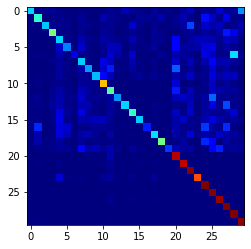

Accuracy of the network on the 2 iteration: 54 %
Train the network, iteration:  3  on classes:  range(30, 40)
[1,    20] loss: 0.069
[1,    40] loss: 0.057
[2,    20] loss: 0.056
[2,    40] loss: 0.053
[3,    20] loss: 0.049
[3,    40] loss: 0.048
[4,    20] loss: 0.046
[4,    40] loss: 0.045
[5,    20] loss: 0.043
[5,    40] loss: 0.043
[6,    20] loss: 0.042
[6,    40] loss: 0.042
[7,    20] loss: 0.041
[7,    40] loss: 0.040
[8,    20] loss: 0.040
[8,    40] loss: 0.040
[9,    20] loss: 0.040
[9,    40] loss: 0.039
[10,    20] loss: 0.041
[10,    40] loss: 0.039
[11,    20] loss: 0.038
[11,    40] loss: 0.038
[12,    20] loss: 0.039
[12,    40] loss: 0.038
[13,    20] loss: 0.037
[13,    40] loss: 0.038
[14,    20] loss: 0.039
[14,    40] loss: 0.037
[15,    20] loss: 0.037
[15,    40] loss: 0.036
[16,    20] loss: 0.037
[16,    40] loss: 0.038
[17,    20] loss: 0.039
[17,    40] loss: 0.038
[18,    20] loss: 0.042
[18,    40] loss: 0.039
[19,    20] loss: 0.038
[19,    40] loss: 0.

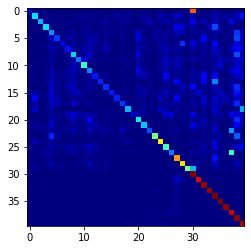

Accuracy of the network on the 3 iteration: 46 %
Train the network, iteration:  4  on classes:  range(40, 50)
[1,    20] loss: 0.085
[1,    40] loss: 0.071
[2,    20] loss: 0.070
[2,    40] loss: 0.067
[3,    20] loss: 0.065
[3,    40] loss: 0.063
[4,    20] loss: 0.062
[4,    40] loss: 0.062
[5,    20] loss: 0.061
[5,    40] loss: 0.059
[6,    20] loss: 0.058
[6,    40] loss: 0.058
[7,    20] loss: 0.057
[7,    40] loss: 0.057
[8,    20] loss: 0.056
[8,    40] loss: 0.056
[9,    20] loss: 0.062
[9,    40] loss: 0.059
[10,    20] loss: 0.057
[10,    40] loss: 0.055
[11,    20] loss: 0.054
[11,    40] loss: 0.053
[12,    20] loss: 0.052
[12,    40] loss: 0.053
[13,    20] loss: 0.055
[13,    40] loss: 0.054
[14,    20] loss: 0.054
[14,    40] loss: 0.054
[15,    20] loss: 0.055
[15,    40] loss: 0.054
[16,    20] loss: 0.054
[16,    40] loss: 0.053
[17,    20] loss: 0.051
[17,    40] loss: 0.051
[18,    20] loss: 0.052
[18,    40] loss: 0.052
[19,    20] loss: 0.051
[19,    40] loss: 0.

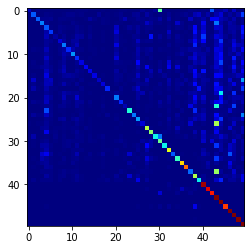

Accuracy of the network on the 4 iteration: 40 %
Train the network, iteration:  5  on classes:  range(50, 60)
[1,    20] loss: 0.094
[1,    40] loss: 0.082
[2,    20] loss: 0.081
[2,    40] loss: 0.079
[3,    20] loss: 0.078
[3,    40] loss: 0.077
[4,    20] loss: 0.073
[4,    40] loss: 0.073
[5,    20] loss: 0.071
[5,    40] loss: 0.072
[6,    20] loss: 0.070
[6,    40] loss: 0.070
[7,    20] loss: 0.068
[7,    40] loss: 0.068
[8,    20] loss: 0.068
[8,    40] loss: 0.068
[9,    20] loss: 0.066
[9,    40] loss: 0.065
[10,    20] loss: 0.066
[10,    40] loss: 0.065
[11,    20] loss: 0.064
[11,    40] loss: 0.063
[12,    20] loss: 0.064
[12,    40] loss: 0.063
[13,    20] loss: 0.064
[13,    40] loss: 0.063
[14,    20] loss: 0.065
[14,    40] loss: 0.064
[15,    20] loss: 0.064
[15,    40] loss: 0.063
[16,    20] loss: 0.064
[16,    40] loss: 0.063
[17,    20] loss: 0.062
[17,    40] loss: 0.062
[18,    20] loss: 0.063
[18,    40] loss: 0.062
[19,    20] loss: 0.064
[19,    40] loss: 0.

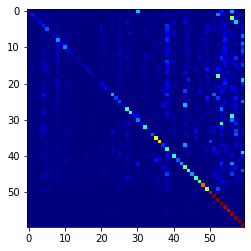

Accuracy of the network on the 5 iteration: 34 %
Train the network, iteration:  6  on classes:  range(60, 70)
[1,    20] loss: 0.107
[1,    40] loss: 0.096
[2,    20] loss: 0.097
[2,    40] loss: 0.097
[3,    20] loss: 0.093
[3,    40] loss: 0.092
[4,    20] loss: 0.089
[4,    40] loss: 0.090
[5,    20] loss: 0.087
[5,    40] loss: 0.086
[6,    20] loss: 0.084
[6,    40] loss: 0.083
[7,    20] loss: 0.083
[7,    40] loss: 0.082
[8,    20] loss: 0.081
[8,    40] loss: 0.082
[9,    20] loss: 0.081
[9,    40] loss: 0.080
[10,    20] loss: 0.080
[10,    40] loss: 0.080
[11,    20] loss: 0.082
[11,    40] loss: 0.082
[12,    20] loss: 0.084
[12,    40] loss: 0.082
[13,    20] loss: 0.079
[13,    40] loss: 0.079
[14,    20] loss: 0.079
[14,    40] loss: 0.078
[15,    20] loss: 0.078
[15,    40] loss: 0.077
[16,    20] loss: 0.076
[16,    40] loss: 0.076
[17,    20] loss: 0.075
[17,    40] loss: 0.076
[18,    20] loss: 0.077
[18,    40] loss: 0.077
[19,    20] loss: 0.076
[19,    40] loss: 0.

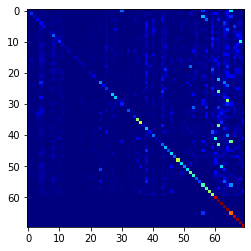

Accuracy of the network on the 6 iteration: 29 %
Train the network, iteration:  7  on classes:  range(70, 80)
[1,    20] loss: 0.123
[1,    40] loss: 0.110
[2,    20] loss: 0.110
[2,    40] loss: 0.108
[3,    20] loss: 0.105
[3,    40] loss: 0.103
[4,    20] loss: 0.101
[4,    40] loss: 0.102
[5,    20] loss: 0.100
[5,    40] loss: 0.099
[6,    20] loss: 0.099
[6,    40] loss: 0.098
[7,    20] loss: 0.098
[7,    40] loss: 0.097
[8,    20] loss: 0.097
[8,    40] loss: 0.096
[9,    20] loss: 0.094
[9,    40] loss: 0.093
[10,    20] loss: 0.093
[10,    40] loss: 0.092
[11,    20] loss: 0.092
[11,    40] loss: 0.092
[12,    20] loss: 0.091
[12,    40] loss: 0.091
[13,    20] loss: 0.090
[13,    40] loss: 0.092
[14,    20] loss: 0.095
[14,    40] loss: 0.093
[15,    20] loss: 0.091
[15,    40] loss: 0.091
[16,    20] loss: 0.091
[16,    40] loss: 0.092
[17,    20] loss: 0.096
[17,    40] loss: 0.094
[18,    20] loss: 0.093
[18,    40] loss: 0.092
[19,    20] loss: 0.092
[19,    40] loss: 0.

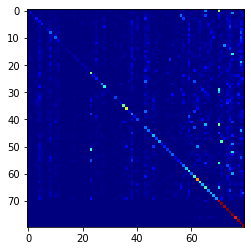

Accuracy of the network on the 7 iteration: 27 %
Train the network, iteration:  8  on classes:  range(80, 90)
[1,    20] loss: 0.130
[1,    40] loss: 0.118
[2,    20] loss: 0.122
[2,    40] loss: 0.118
[3,    20] loss: 0.115
[3,    40] loss: 0.113
[4,    20] loss: 0.110
[4,    40] loss: 0.109
[5,    20] loss: 0.107
[5,    40] loss: 0.106
[6,    20] loss: 0.106
[6,    40] loss: 0.104
[7,    20] loss: 0.104
[7,    40] loss: 0.103
[8,    20] loss: 0.104
[8,    40] loss: 0.103
[9,    20] loss: 0.102
[9,    40] loss: 0.101
[10,    20] loss: 0.101
[10,    40] loss: 0.100
[11,    20] loss: 0.099
[11,    40] loss: 0.099
[12,    20] loss: 0.098
[12,    40] loss: 0.099
[13,    20] loss: 0.099
[13,    40] loss: 0.099
[14,    20] loss: 0.098
[14,    40] loss: 0.098
[15,    20] loss: 0.104
[15,    40] loss: 0.102
[16,    20] loss: 0.104
[16,    40] loss: 0.101
[17,    20] loss: 0.101
[17,    40] loss: 0.099
[18,    20] loss: 0.098
[18,    40] loss: 0.098
[19,    20] loss: 0.099
[19,    40] loss: 0.

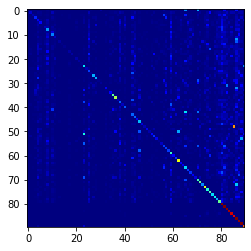

Accuracy of the network on the 8 iteration: 25 %
Train the network, iteration:  9  on classes:  range(90, 100)
[1,    20] loss: 0.138
[1,    40] loss: 0.124
[2,    20] loss: 0.126
[2,    40] loss: 0.123
[3,    20] loss: 0.122
[3,    40] loss: 0.121
[4,    20] loss: 0.118
[4,    40] loss: 0.117
[5,    20] loss: 0.116
[5,    40] loss: 0.115
[6,    20] loss: 0.115
[6,    40] loss: 0.112
[7,    20] loss: 0.111
[7,    40] loss: 0.111
[8,    20] loss: 0.112
[8,    40] loss: 0.111
[9,    20] loss: 0.114
[9,    40] loss: 0.112
[10,    20] loss: 0.115
[10,    40] loss: 0.112
[11,    20] loss: 0.111
[11,    40] loss: 0.110
[12,    20] loss: 0.108
[12,    40] loss: 0.108
[13,    20] loss: 0.109
[13,    40] loss: 0.108
[14,    20] loss: 0.111
[14,    40] loss: 0.109
[15,    20] loss: 0.109
[15,    40] loss: 0.109
[16,    20] loss: 0.109
[16,    40] loss: 0.109
[17,    20] loss: 0.110
[17,    40] loss: 0.109
[18,    20] loss: 0.109
[18,    40] loss: 0.108
[19,    20] loss: 0.108
[19,    40] loss: 0

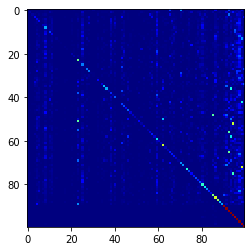

Accuracy of the network on the 9 iteration: 22 %


In [ ]:
#TRYING TO RANDOMIZE CLASSES


# divided our dataset into sample of 10 classes each
# train the network on the first 10 classes
# evaluate the network on the first 10 classes
# train the network on the second 10 classes (adding 10 output layers)
# evaluate the network on the first 20 classes
iterations = 10 #5
num_classes = 10 #20
test_set = [] #initialized here because we test over all the classes not only those one in which I train
acc = []

for i in range(iterations):
  classes_current_iter = range(i*num_classes, i*num_classes+num_classes)
  train_iter = []
  for j in range(len(trainset)):
    if(trainset[j][-1] in classes_current_iter):
      test_set.append(trainset[j]) 
      train_iter.append(trainset[j])

  train_loader = torch.utils.data.DataLoader(train_iter, shuffle = True, batch_size=batch_size, num_workers=2)
  valid_loader = torch.utils.data.DataLoader(test_set, shuffle = True, batch_size = batch_size, num_workers=2) 
  print("Train the network, iteration: ", i, " on classes: ", classes_current_iter)
  
  training(train_loader, i, net, device, epochs, num_classes) # Train the network with 10 classes at a time
  print("after training: ", net.fc.weight.data)
  #test(valid_loader, i, net, acc) # Test the network with all classes seen until this iteration